Importing all the required Libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense,Conv2D,GlobalAvgPool2D,Input
from tensorflow.keras import callbacks,optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10

 99% 579M/586M [00:06<00:00, 189MB/s]
100% 586M/586M [00:06<00:00, 99.9MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/animals10.zip', 'r')
zip_ref.extractall('/content/Animal')
zip_ref.close()

In [5]:
%cd /content/Animal

/content/Animal


In [6]:
from translate import translate

In [7]:
translate

{'cane': 'dog',
 'cavallo': 'horse',
 'elefante': 'elephant',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'scoiattolo': 'squirrel',
 'dog': 'cane',
 'elephant': 'elefante',
 'butterfly': 'farfalla',
 'chicken': 'gallina',
 'cat': 'gatto',
 'cow': 'mucca',
 'spider': 'ragno',
 'squirrel': 'scoiattolo'}

In [8]:
os.listdir("/content/Animal/raw-img")

['cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'pecora',
 'scoiattolo',
 'cane',
 'ragno',
 'mucca',
 'gatto']

In [9]:
#manually renaming specific directory
for i in os.listdir("/content/Animal/raw-img"):
  try:
    os.rename("/content/Animal/raw-img/"+i,"/content/Animal/raw-img/"+translate[i])
  except Exception as e:
    print(e)
os.rename("/content/Animal/raw-img/ragno","/content/Animal/raw-img/spider")
#os.rename("/content/Animal/raw-img/scoiattolo","/content/Animal/raw-img/squirrel")

'ragno'


In [10]:
ls /content/Animal/raw-img

butterfly/  cat/  chicken/  cow/  dog/  elephant/  horse/  sheep/  spider/  squirrel/


In [11]:
for i in os.listdir("/content/Animal/raw-img"):
  print(i,len(os.listdir("/content/Animal/raw-img/"+i)))

dog 4863
spider 4821
elephant 1446
cow 1866
squirrel 1862
chicken 3098
sheep 1820
cat 1668
butterfly 2112
horse 2623


In [12]:
try:
  os.mkdir("train")
  os.mkdir("test")
except:
  pass
for i in os.listdir("/content/Animal/raw-img"):
  try:
    os.mkdir("train/"+i)
    os.mkdir("test/"+i)
  except:
    pass
  for j in os.listdir("/content/Animal/raw-img/"+i)[:1000]:
    os.rename("/content/Animal/raw-img/"+i+"/"+j,"train/"+i+"/"+j)
  for j in os.listdir("/content/Animal/raw-img/"+i)[:400]:
    os.rename("/content/Animal/raw-img/"+i+"/"+j,"test/"+i+"/"+j)

Set path to Dataset

In [13]:
train_dir = '/content/Animal/train'
validation_dir = '/content/Animal/test'

In [14]:
len(os.listdir("/content/Animal/raw-img"))

10

Setting up th Paramaters

In [15]:
num_classes = 10
image_size = (224, 224)
batch_size = 32
learning_rate = 0.001
epochs = 5

Preprocessing and augument the training data

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

Preprocess the validation data

In [17]:
valid_datagen = ImageDataGenerator(rescale=1./255)

Load the inceptionv3 model

In [18]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

87910968/87910968 [==============================] - 0s 0us/step


Adding the top layer for the model

In [19]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(500, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

Combine base model with top layer

In [20]:
model = Model(inputs=base_model.input, outputs=predictions)

Freeze the layers in base model

In [21]:
for layer in base_model.layers:
  layer.trainable = False

Compile the model

In [22]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Generate the training and validation data from directories

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 10000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [24]:
train_generator.class_indices

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

In [25]:
base_model.trainable = False

Train the model

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size
)

Epoch 1/5
312/312 [==============================] - 148s 443ms/step - loss: 0.3141 - accuracy: 0.9094 - val_loss: 0.1732 - val_accuracy: 0.9477
Epoch 2/5
312/312 [==============================] - 137s 440ms/step - loss: 0.1832 - accuracy: 0.9413 - val_loss: 0.1857 - val_accuracy: 0.9417
Epoch 3/5
312/312 [==============================] - 136s 437ms/step - loss: 0.1461 - accuracy: 0.9547 - val_loss: 0.1547 - val_accuracy: 0.9545
Epoch 4/5
312/312 [==============================] - 138s 442ms/step - loss: 0.1371 - accuracy: 0.9566 - val_loss: 0.1705 - val_accuracy: 0.9495
Epoch 5/5
312/312 [==============================] - 137s 439ms/step - loss: 0.1257 - accuracy: 0.9591 - val_loss: 0.1635 - val_accuracy: 0.9510


125/125 [==============================] - 10s 80ms/step - loss: 0.1635 - accuracy: 0.9510
Validation Loss: 0.1635456383228302
Validation Accuracy: 0.9509999752044678


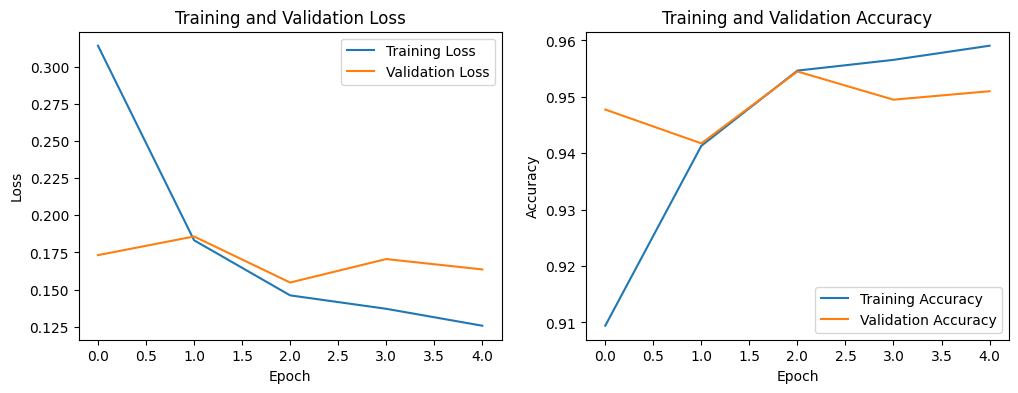

In [27]:

# Model Evaluation
evaluation = model.evaluate(valid_generator, steps=valid_generator.n // batch_size)

# Displaying the Evaluation Metrics
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

# Plotting Training and Validation Curves
plt.figure(figsize=(12, 4))

# Plotting Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [28]:
model.save("/content/Animal_Classification.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing the model

Saving ea37b70e21f6043ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg to ea37b70e21f6043ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
1/1 [==============================] - 3s 3s/step


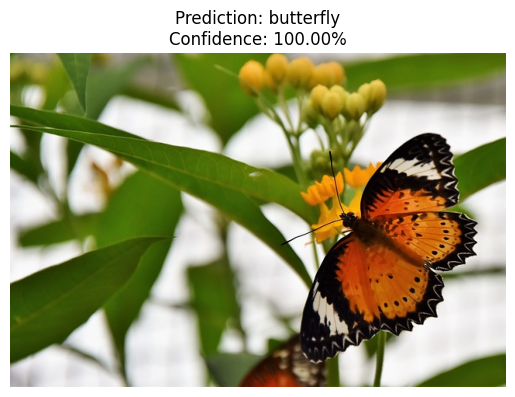

In [29]:
import PIL.Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


model = tf.keras.models.load_model('/content/Animal_Classification.h5')


class_labels = ['butterfly' , 'cat' , 'chicken' , 'cow' , 'dog' , 'elephant' , 'horse' , 'sheep' , 'spider' , 'squirrel']


def preprocess_image(image_path):
    img = PIL.Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def predict_animal(image_path):
    processed_image = preprocess_image(image_path)
    predictions = model.predict(processed_image)
    predicted_label = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_label, confidence


from google.colab import files
uploaded = files.upload()


uploaded_file_path = list(uploaded.keys())[0]


prediction, confidence = predict_animal(uploaded_file_path)


img = PIL.Image.open(uploaded_file_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Prediction: {prediction}\nConfidence: {confidence:.2%}')
plt.show()

In [30]:
%%writefile app.py
import cv2
import numpy as np
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input as mobilenet_v2_preprocess_input

st.title("Animal Image Detection Application")
st.header("Image Classifier ")

model = tf.keras.models.load_model("/content/Animal_Classification.h5")
### load file
uploaded_file = st.file_uploader("Upload an Image for Image classification", type=["jpg","jpeg","png"])

map_dict = { 0: 'butterfly',
             1: 'cat',
             2: 'chicken',
             3: 'cow',
             4: 'dog' ,
             5: 'elephant',
             6: 'horse',
             7: 'sheep',
             8: 'spider',
             9: 'squirrel'}


if uploaded_file is not None:
    # Convert the file to an opencv image.
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    opencv_image = cv2.imdecode(file_bytes, 1)
    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(opencv_image,(224,224))
    # Now do something with the image! For example, let's display it:
    st.image(opencv_image, channels="RGB")

    resized = mobilenet_v2_preprocess_input(resized)
    img_reshape = resized[np.newaxis,...]

    Genrate_pred = st.button("Generate Prediction")
    if Genrate_pred:
        prediction = model.predict(img_reshape).argmax()
        st.title("Predicted Label for the image is {}".format(map_dict [prediction]))

Writing app.py


In [31]:
!pip install streamlit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501